In [1]:
from platform import python_version
python_version()

'3.7.4'

In [2]:
import os
import pandas as pd
import json
import tqdm
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
from motif_utils import seq2kmer
import operator
import random
import itertools
import tqdm
import pickle

In [3]:
import css_utility

[NbConvertApp] Converting notebook css_utility.ipynb to script
[NbConvertApp] Writing 44344 bytes to css_utility.py


In [4]:
from css_utility import *

In [5]:
path='../database/hg19/genome_per_chr/'
# chr_list=[os.path.join(path, file) for file in sorted(os.listdir(path))]
chr_list=[(file, os.path.join(path, file)) for file in sorted(os.listdir(path)) if "chrM" not in file]

In [7]:
path='../database/bed/unzipped/'

In [8]:
all_files=file_list_maker(path, bed_files)
test_file_bed=all_files[0]
df=bed2df_expanded(test_file_bed)

In [9]:
len(chr_list)

24

In [8]:
chr1=chr_list[0][1]
chr1

'../database/hg19/genome_per_chr/chr1'

In [99]:
with open(chr1) as infile:
    all_n_line="N"*50
    all_n_index=[]
    for i, line in enumerate(infile):
        if i==0:
            print(i, line, line.count("N"))
        elif all_n_line in line:
            all_n_index.append(i)

0 NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
 50


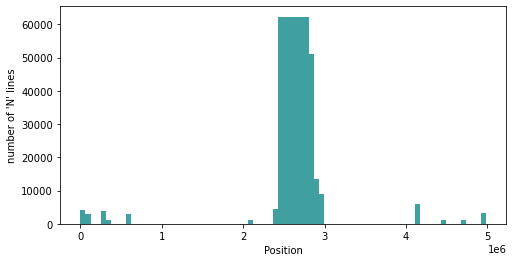

In [14]:
fig=plt.figure(figsize=(8,4))
plt.hist(all_n_index,80, facecolor='teal', alpha=0.75)
plt.xlabel("Position")
plt.ylabel("number of 'N' lines")
plt.show()

In [15]:
def chrNdist(chr_file=chr1):   # do it for a whole genome except for chrM
    """
    input: divided genome by chromosome (without any index, only genome)
    output: dataframe of [start, end] position of "N" in the genome sequence
    """
    with open(chr_file) as infile:
        all_n_line="N"*50    # python reads text line by 50 characters
        all_n_index=[]
        all_n_start=[1]
        all_n_end=[]

        for i, line in enumerate(infile):
            if all_n_line in line:
                all_n_index.append(i)    # all_n_index is a list of N

        for i, num in enumerate(all_n_index):   
            if i==0:        
                pre_num=num
            elif num !=pre_num+1:
                all_n_start.append(num)
            pre_num=num   
        for i, num in enumerate(all_n_index):   
            if i==0:        
                pre_num=num
            elif num !=pre_num+1:
                all_n_end.append(pre_num+1)
            pre_num=num
        all_n_end.append(all_n_index[-1]+1)

        assert len(all_n_start)==len(all_n_end)
        
        n_dist_df=pd.DataFrame({"start":all_n_start,"end":all_n_end, 
                                "count":[e-s+1 for s,e in zip(all_n_start,all_n_end)]},
                               columns=["start","end","count"])
        ######## uncomment this block if you want to draw the histogram!
#         fig=plt.figure(figsize=(8,4))
#         plt.hist(all_n_index, 50, facecolor='teal', alpha=0.75)
#         plt.xlabel("Position")
#         plt.ylabel("number of 'N' lines")
#         plt.show()
        return all_n_index, n_dist_df

In [361]:
def all_chr_Ndist(ref_genome_path='../database/hg19/genome_per_chr/', normalization=True):
    
    """
    input: ref_genome_path='../database/hg19/genome_per_chr/'
    output: all_chr_n_index_norm (normalization ON) / all_chr_n_index (normalization OFF)
    option: normalization (all chromosome length= 0 to 1 for drawing a dist. graph)
    """
    
    path=ref_genome_path
    chr_list=[(file, os.path.join(path, file)) for file in sorted(os.listdir(path)) if "chrM" not in file] # remove chrM
    
    fig=plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    
    all_chr_n_index=[] # list of list (raw data)
    all_chr_n_index_norm=[] # list of list (normalized data)
    
    for i, (chr_no, chr_path) in enumerate(chr_list):
        all_n_index, n_dist_df=chrNdist(chr_path)
        # save the raw data
        all_chr_n_index.append(all_n_index)
        
        ########### normalization here ###########
        all_n_index_norm=[elm/all_n_index[-1] for elm in all_n_index]
        ##########################################
        
#         grad_color=plt.cm.viridis_r(i*10)
#         grad_color=plt.cm.coolwarm(i*10)
        grad_color=plt.cm.terrain(i*10)
#         ax.hist(all_n_index_norm, 100, color=grad_color, ec='white', alpha=0.5, label=chr_no)
        ax.hist(all_n_index_norm, 50, color=grad_color, histtype="step", label=chr_no)
        all_chr_n_index_norm.append(all_n_index_norm)
        
    ### show only the normalized disribution
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis's height by 20% on the bottom
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Normalized Position")
    plt.ylabel("number of 'N' lines")
    plt.grid(b=None)

    plt.show()  
    
    if normalization:
        return all_chr_n_index_norm 
    else:
        return all_chr_n_index

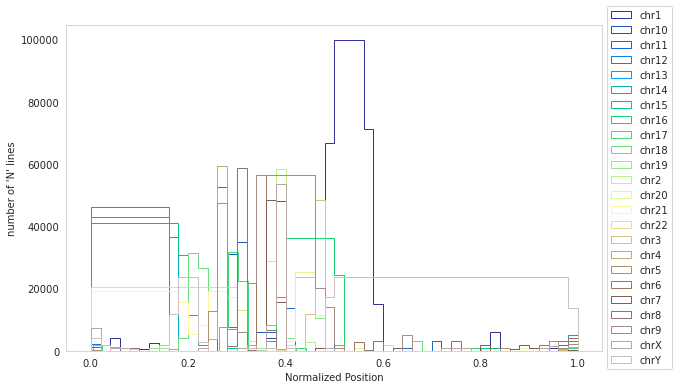

In [362]:
all_chr_n_index_norm=all_chr_Ndist(ref_genome_path='../database/hg19/genome_per_chr/', normalization=True)

In [327]:
# index list for O state in unit-length css sequence:
def UnitCSS_Q_Dist(df, chr_no=1):
    all_unit_css=df2unitcss(df)
    chr_unit_css=all_unit_css[chr_no]
    q_index=[]
    for i,state in enumerate(chr_unit_css):
        if state=="O":
            q_index.append(i)
    ######## uncomment this block if you want to draw the histogram!
#     fig=plt.figure(figsize=(8,4))
#     plt.hist(q_index, 30, histtype="step", color='orange')
# #     sns.histplot(q_index, kde=False, color='orange', bins=30, element="step", fill=False)

#     plt.xlabel("Position")
#     plt.ylabel("number of 'O' state")
#     plt.show()
    return q_index

In [354]:
q_index=UnitCSS_Q_Dist(df, chr_no=0)

In [342]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [344]:
all_unit_css=df2unitcss(df)
len(all_unit_css)

24

In [363]:
def all_chr_UnitCSS_Q_Dist(df,normalization=True):
    
    """
    input: df (the dataframe acquired by bed2df_expanded function for a chromatin state bed file)
    output: all_chr_q_index_norm (normalization ON) / all_chr_q_index (normalization OFF)
    option: normalization (all chromosome length= 0 to 1 for drawing a dist. graph)
    """
    
    all_unit_css=df2unitcss(df)  # a list of unit-css of df sample, chromosome wise
       
    fig=plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    all_chr_q_index=[] # list of list (raw data)
    all_chr_q_index_norm=[] # list of list (normalized data)
    
    for i in range(len(all_unit_css)):
        q_index=UnitCSS_Q_Dist(df, chr_no=i)
        all_chr_q_index.append(q_index)
        
        ########### normalization here ###########
        q_index_norm=[elm/q_index[-1] for elm in q_index]
        ##########################################
        all_chr_q_index_norm.append(q_index_norm)
        if i <=21:
            chr_name="chr"+str(i+1)
        elif i==23:
            chr_name="chrX"
        else:
            chr_name="chrY"

        grad_color=plt.cm.coolwarm(i*10)
#         ax.hist(q_index_norm, 100, color=grad_color, ec='white', alpha=0.5, label=chr_no)
        ax.hist(q_index_norm, 50, color=grad_color, histtype="step", label=chr_name)

    ### show only the normalized disribution
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis's height by 20% on the bottom
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Normalized Position")
    plt.ylabel("number of 'O' state")
    plt.grid(b=None)
    
    if normalization:
        return all_chr_q_index_norm
    else:
        return all_chr_q_index


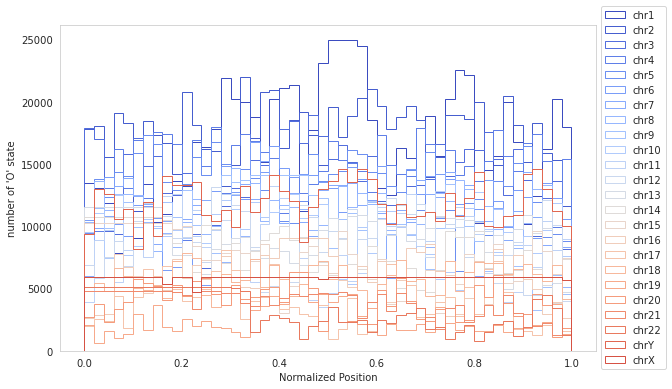

In [364]:
all_chr_q_index_norm=all_chr_UnitCSS_Q_Dist(df, normalization=True)

In [296]:
unit_css_01_chr1=all_unit_css[0]

In [297]:
len(q_index)

873207

In [298]:
def chr_cssWOteloKmer(df,chr_no,k):
    
    all_unit_css=df2unitcss(df)
    
    ch1_unit_css=all_unit_css[chr_no]
    ch1_unit_css_wotelo=ch1_unit_css[50:-50]
    ch1_unit_css_wotelo_kmer=seq2kmer(ch1_unit_css_wotelo,k)
    
    path='../database/wo_telo/'
    fn_base="chr"+str(chr_no)+"_"+str(k)+"_wo_telo_v1"   # version 1 (Oct. 2022)
    ext=".txt"
          
    fn=path+fn_base+ext  # file name

    with open(fn,"w") as save_file:
        save_file.write("".join(ch1_unit_css_wotelo_kmer))
          
    return print("unit-length css of {} for {}mer was saved at {}".format(chr_no, k, path))

In [299]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [300]:
# start from df, make it into css, removing chrM

all_unit_css=df2unitcss(df)
len(all_unit_css)

24

In [301]:
len(all_unit_css[23])

296867

In [302]:
len(all_unit_css[0][50:-50])==len(all_unit_css[0])-100

True

In [303]:
seq2kmer(all_unit_css[0][50:-50],6)[:30]

'IIIOOO IIOOOO IOOOOO OOOOOO OO'

In [304]:
ch1_unit_css=all_unit_css[0]

In [305]:
test_string=ch1_unit_css[50:-50][:100]
test_string

'IIIOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [20]:
string = 'OOIIIIIIIIIIIIIIIIIIIIOOOOOOOOOOOOOOOOOOOAAAAAAAAAAAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'
splitted = []

prev = 0
while True:
    n = random.randint(5,10)
    splitted.append(string[prev:prev+n])
    prev = prev + n
    if prev >= len(string)-1:
        break
    "\n".join(splitted)
print(splitted)

['OOIIIII', 'IIIIII', 'IIIIIII', 'IIOOOOOOO', 'OOOOO', 'OOOOOO', 'OAAAA', 'AAAAAAAAA', 'AAAOOOOO', 'OOOOOOO', 'OOOOOO', 'OOOOOOO', 'OOOO']


In [120]:
n=random.choice([5,10])
split_test_string=[test_string[num:num+n] for num in range(0,len(test_string),n)]
split_test_string

['IIIOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO',
 'OOOOOOOOOO']

In [207]:
ori_lst=[elm for elm in range(5,511)]
sin_lst=[510]*506
tot_lst=ori_lst+sin_lst

type(tot_lst)

list

In [208]:
print("ori_lst", len(ori_lst))
print("sin_lst", len(sin_lst))

ori_lst 506
sin_lst 506


In [218]:
random.choice(tot_lst)

292

In [230]:
num_lst=[]
for i in range(100):
    num=random.choice(tot_lst)
    num_lst.append(num)
num_lst.count(510)/len(num_lst)

0.56

In [13]:
# randomly cut the string #### reflect it!

def chr_cssWOtelo_ranCUT_Kmer(df,chr_no,num1=5,num2=510, k=3, weight_rn=False, v_name="v1.01"):
    """
    Usage: chr_cssWOtelo_ranCUT_Kmer(df,chr_no,num1,num2, weight_rn, k, v_name)
    
    - df: expanded version of 1 sample bed file
    - chr_no: no. of chromosome
    - num1: cut range start
    - num2: cut range end
    - weight_rn: 
      if True: random with weighted, 50% of chance to be num2, 50% random between num1 and num2
      if False: random between num1 and num2
    - k: kmer
    - v_name: version name to be used as a file name 
      (Conventionally, 01 was used for weighted_rn False, 02 for True
       v1 just stands for telomere is set to be 50 unit)
    
    output: randomly cut w15 css for one chromosome unit-length css
    """
    all_unit_css=df2unitcss(df)
    
    ch1_unit_css=all_unit_css[chr_no]
    ch1_unit_css_wotelo=ch1_unit_css[50:-50] #cut the telomere

    splitted=[]
    prev=0

    ori_lst=[elm for elm in range(num1,num2+1)]   # list of num between num1 and num2
    sin_lst=[num2]*len(ori_lst)   # list of all num2 (length is the same of ori_lst)
    tot_lst=ori_lst+sin_lst
    
    while True:
        
        if weight_rn:
            n=random.choice(tot_lst)

        else:
            n=random.randint(num1,num2)
        
        splitted.append(ch1_unit_css_wotelo[prev:prev+n])
        prev=prev+n
        if prev >= len(ch1_unit_css_wotelo)-1:
            break
   
    ch1_unit_css_wotelo_kmer=[seq2kmer(item, k) for item in splitted]
    
      
    path='../database/wo_telo/'
    fn_base="chr"+str(chr_no)+"_"+str(k)+"_wo_telo_"+v_name   # version 1.01 (Oct. 2022) : telo 50 unit, rn 200-1000
                                                              # version 1.02 (Oct. 2022) : telo 50, rn 5 - 510
    ext=".txt"
          
    fn=path+fn_base+ext  # file name

    with open(fn,"w") as save_file:
        save_file.write("\n".join(ch1_unit_css_wotelo_kmer))
          
    return print("unit-length css of chr{} cut randomly(weighted range:{}-{}) for {}mer was saved at {}".format(chr_no, num1, num2, k,fn))

In [383]:
# chr_cssWOtelo_ranCUT_Kmer(df,1,num1=5,num2=510, k=3,v_name="v1.02")

In [18]:
chr_cssWOtelo_ranCUT_Kmer(df, chr_no=1, num1=5, num2=510, k=3, v_name="v1.01")

unit-length css of chr1 cut randomly(weighted range:5-510) for 3mer was saved at ../database/wo_telo/chr1_3_wo_telo_v1.01.txt


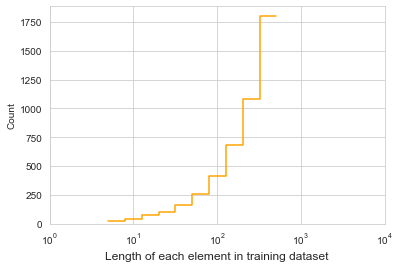

In [40]:
dataLengCompo('../database/wo_telo/chr1_3_wo_telo_v1.01.txt',3,"orange",10) # now same version with 4,5,6

In [384]:
chr_cssWOtelo_ranCUT_Kmer(df, chr_no=1, num1=5, num2=510, k=6, v_name="v1.01")

unit-length css of chr1 cut randomly(weighted range:5-510) for 6mer was saved at ../database/wo_telo/chr1_6_wo_telo_v1.01.txt


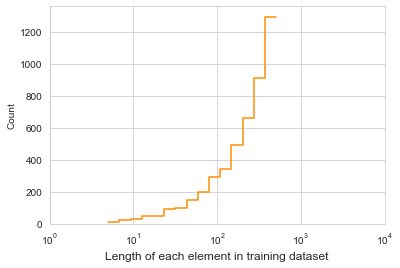

In [27]:
# check it with dataLengCompo when it is finished!
dataLengCompo('../database/wo_telo/chr1_6_wo_telo_v1.01.txt',6,"darkorange")

unit-length css of chr1 cut randomly(weighted range:5-510) for 5mer was saved at ../database/wo_telo/chr1_5_wo_telo_v1.01.txt


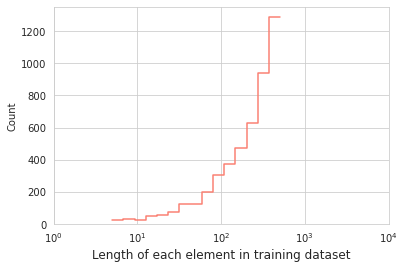

In [395]:
chr_cssWOtelo_ranCUT_Kmer(df, chr_no=1, num1=5, num2=510, k=5, v_name="v1.01")
dataLengCompo('../database/wo_telo/chr1_5_wo_telo_v1.01.txt',5,"salmon")

In [400]:
chr_cssWOtelo_ranCUT_Kmer(df, chr_no=1, num1=5, num2=510, k=4, v_name="v1.01")

unit-length css of chr1 cut randomly(weighted range:5-510) for 4mer was saved at ../database/wo_telo/chr1_4_wo_telo_v1.01.txt


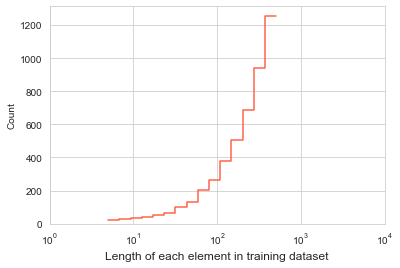

In [39]:
dataLengCompo('../database/wo_telo/chr1_4_wo_telo_v1.01.txt',4,"tomato")

In [38]:
def dataLengCompo(path, k, color="teal", bins=15, dna=False):
    """
    Create a histogram of data length (elements before k-merization in the training dataset list)
    """
    file_name=path
    with open(file_name) as f:
        len_lst=[]
        for line_no, line in enumerate(f):
            if dna:
                line_len=int((len(line)-1)/k)+(k-1)  # -1 comes from the space only between DNA sequence kmer
                if line_len!=0:
                    len_lst.append(line_len)               
            else:
                line_len=int(len(line)/(k+1))+(k-1)  # reduced 
#                 line_len=int(len(line)/(k+1))*k # +1 comes from the space after the kmers
                len_lst.append(line_len)
                
    fig=plt.figure(figsize=(6,4))
    
    s=sns.histplot(len_lst, kde=False, color=color, log_scale=True, bins=bins, element="step", fill=False)
    sns.set_style("whitegrid")
    plt.xlabel("Length of each element in training dataset", fontsize=12)
    plt.xlim([1,10000])
    plt.show()
    return          

In [26]:
dataLengCompo('../database/test_data/3_tr01.txt',3)

FileNotFoundError: [Errno 2] No such file or directory: '../database/test_data/3_tr01.txt'

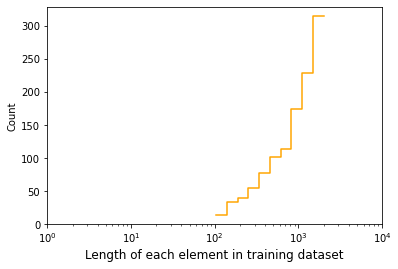

In [21]:
dataLengCompo('../database/wo_telo/chr1_3_wo_telo_v1.01_pre.txt',3,"orange",10) #random, 100-2000

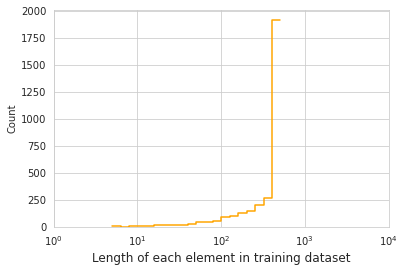

In [280]:
dataLengCompo('../database/wo_telo/chr1_3_wo_telo_v1.02.txt',3,"orange",20)

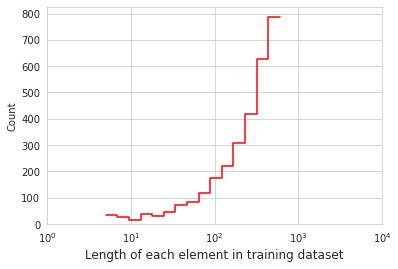

In [281]:
dataLengCompo('../database/sample_data/pre/6_3k.txt',6,"red",dna=True)

In [159]:
fn='../database/wo_telo/3_wo_telo_v1.txt'
with open(fn, "r") as f:
    
    for line_no, line in enumerate(f):
        

0 61903684


In [150]:
# def ranCut(target_string, num1, num2):
#     splitted=[]
#     prev=0
#     while True:       
#         n=random.randint(num1,num2)
#         splitted.append(target_string[prev:prev+n])
#         prev=prev+n
#         if prev >= len(target_string)-1:
#             break
    
#     return splitted

In [90]:
def chr_cssWOteloKmer(df,chr_no,k):
    
    all_unit_css=df2unitcss(df)
    
    ch1_unit_css=all_unit_css[chr_no]
    ch1_unit_css_wotelo=ch1_unit_css[50:-50]
    ch1_unit_css_wotelo_kmer=seq2kmer(ch1_unit_css_wotelo,k)
    
    path='../database/wo_telo/'
    fn_base="chr"+str(chr_no)+"_"+str(k)+"_wo_telo_v1"   # version 1 (Oct. 2022)
    ext=".txt"
          
    fn=path+fn_base+ext  # file name

    with open(fn,"w") as save_file:
        save_file.write("".join(ch1_unit_css_wotelo_kmer))
          
    return print("unit-length css of {} for {}mer was saved at {}".format(chr_no, k, path))
        

In [91]:
chr_cssWOteloKmer(df,1,3)

unit-length css of 1 for 3mer was saved at ../database/wo_telo/


In [61]:
def cssWOteloKmer(df,k):
    """
    description: Create and save a list of css trimming the telometer region (10,000 bp = 50 unit)
    input: df (bed to df, containing all chr), k (number for k-mer)
    output: saved file (kmer css at '../database/wo_telo/')
    """
    all_unit_css=df2unitcss(df) # unit-long css for 
    
    ### telomere is set to 10,000 at the initial and final genome sequences
    ### unit length is 200-bp resolution, 50 units are telomeres
    
    print("{}mer prepraration process for telomere-less data has been started...".format(k))
    
    total_lst_wotelo=[]
    for i in range(len(all_unit_css)):
        unit_css=all_unit_css[i]
        unit_css_wotelo=unit_css[50:-50]  # cut initial-final 50 units
        unit_css_wotelo_kmer=seq2kmer(unit_css_wotelo,k)
        
        total_lst_wotelo+=unit_css_wotelo_kmer  # didn't use [append], as it adds as a list per se 
        
    path='../database/wo_telo/'
    fn_base=str(k)+"_wo_telo_v1"   # version 1 (Oct. 2022)
    ext=".txt"
          
    fn=path+fn_base+ext  # file name

    with open(fn,"w") as save_file:
        save_file.write("".join(total_lst_wotelo))
          
    return print("unit-length css for {}mer was saved at {}".format(k, path))

In [62]:
cssWOteloKmer(df,6)

6mer prepraration process for telomere-less data has been started...
unit-length css for 6mer was saved at ../database/wo_telo/


In [63]:
cssWOteloKmer(df,5)

5mer prepraration process for telomere-less data has been started...
unit-length css for 5mer was saved at ../database/wo_telo/


In [64]:
cssWOteloKmer(df,4)

4mer prepraration process for telomere-less data has been started...
unit-length css for 4mer was saved at ../database/wo_telo/


In [65]:
cssWOteloKmer(df,3)

3mer prepraration process for telomere-less data has been started...
unit-length css for 3mer was saved at ../database/wo_telo/


In [ ]:
with open("test_css2txt.txt","w") as ws:
    ws.write(all_chr_css)

In [35]:
path='../database/wo_telo/'
fn_base="wo_telo_chr"
ext=".txt"
i=1
path+fn_base+str(i)+ext

'../database/wo_telo/wo_telo_chr1.txt'

In [10]:
path='../database/bed/unzipped/'
bed_files=os.listdir(path)

In [11]:
all_files=file_list_maker(path, bed_files)
test_file_bed=all_files[0]
df=bed2df_expanded(test_file_bed)

In [22]:
all_files[0]

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [12]:
df.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
510145,chrY,59003800,59005800,15,2000,10,O,OOOOOOOOOO
510146,chrY,59005800,59006000,9,200,1,I,I
510147,chrY,59006000,59011800,15,5800,29,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOO
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
510149,chrY,59026000,59373400,15,347400,1737,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [64]:
df_chr_list=df2chr_df(df)

In [65]:
len(df_chr_list)

25

In [351]:
df.groupby("chromosome").count()

,start,end,state,length,unit,state_seq,state_seq_full
chromosome,,,,,,,
chr1,39931,39931,39931,39931,39931,39931,39931
chr10,21242,21242,21242,21242,21242,21242,21242
chr11,22440,22440,22440,22440,22440,22440,22440
chr12,21977,21977,21977,21977,21977,21977,21977
chr13,11932,11932,11932,11932,11932,11932,11932
chr14,15867,15867,15867,15867,15867,15867,15867
chr15,14905,14905,14905,14905,14905,14905,14905
chr16,15820,15820,15820,15820,15820,15820,15820
chr17,18224,18224,18224,18224,18224,18224,18224


In [67]:
all_unit_css=df2unitcss(df)
len(all_unit_css)

24

In [22]:
set(all_unit_css[0][:3000])

{'A', 'I', 'O'}

In [26]:
all_unit_css[0][:3000].count("O")

2993

In [27]:
test_6mer=seq2kmer(all_unit_css[0],6)

In [28]:
type(test_6mer)

str

In [29]:
len(test_6mer)

8723735

In [42]:
test_6mer[:100][6]==' '

True

In [65]:
def colored_css_str_as_is(sub_str):
    col_str=""
    for letter in sub_str:
        if letter==" ":
            col_str+=" "
        else:                
            for state in list(state_col_255_dict.keys()):
                if letter==state:
                    r=state_col_255_dict[letter][0]
                    g=state_col_255_dict[letter][1]
                    b=state_col_255_dict[letter][2]
                    col_letter="\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r,g,b,letter)
                    col_str+=col_letter
    return print("\033[1m"+col_str+"\033[0;0m") 

In [66]:
colored_css_str_as_is(test_6mer[300:350])

 O O O O O O  O O O O O I  O O O O I I  O O O I I I  O O I I I I  O I I I I O  I I I I O O  


In [76]:
len(all_unit_css[:])

24

In [77]:
# flattening list of list
flat_css=[item for sublist in all_unit_css for item in sublist]

In [78]:
len(flat_css)

15478375

In [80]:
flat_css.count("O")/len(flat_css)

0.7097894320301711

In [81]:
flat_css.count("A")/len(flat_css)

0.00998321852261623

In [110]:
pd.concat([prop_data_01["state (Emission order)"],prop_data_01["Genome %"]], axis=1)

,state (Emission order),Genome %
0,1_TssA,0.99832
1,2_TssAFlnk,0.25765
2,3_TxFlnk,0.02896
3,4_Tx,1.37933
4,5_TxWk,14.20635
5,6_EnhG,0.09142
6,7_Enh,3.73125
7,8_ZNF/Rpts,0.25855
8,9_Het,2.65723
9,10_TssBiv,0.40156


In [115]:
a_df=pd.DataFrame(prop_data_01["state (Emission order)"])

In [119]:
a_s=prop_data_01["Genome %"]

In [134]:
a_s.index()

TypeError: 'RangeIndex' object is not callable

In [121]:
n_df=pd.concat([a_df,a_s], axis=1)

In [122]:
pd.concat([n_df,a_s], axis=1)

,state (Emission order),Genome %,Genome %
0,1_TssA,0.99832,0.99832
1,2_TssAFlnk,0.25765,0.25765
2,3_TxFlnk,0.02896,0.02896
3,4_Tx,1.37933,1.37933
4,5_TxWk,14.20635,14.20635
5,6_EnhG,0.09142,0.09142
6,7_Enh,3.73125,3.73125
7,8_ZNF/Rpts,0.25855,0.25855
8,9_Het,2.65723,2.65723
9,10_TssBiv,0.40156,0.40156


In [346]:
def prop_data2df(path='../database/conserv_overlap/', state_list=state_list):
    file_list=[os.path.join(path, file) for file in os.listdir(path)]
    
    temp_df=pd.read_csv(file_list[0],sep='\t', lineterminator='\n')
    init_col=pd.DataFrame(temp_df["state (Emission order)"])
    init_col=init_col.rename(columns={"state (Emission order)":"state"})
    for file in file_list:
        file_name=file.split('/')[3]
        sample_name=file_name.split('_')[0]

        prop_data=pd.read_csv(file, sep='\t', lineterminator='\n')
        prop=prop_data["Genome %"]
        temp_df=pd.concat([init_col,prop], axis=1)
        temp_df=temp_df.rename(columns={"Genome %":str(sample_name)})
        init_col=temp_df
    
    # show the result df (first col=state, other col=samples)
    temp_df.drop(temp_df.tail(1).index, inplace=True) # remove the last row (100%)
    
    # transposed and trimmed df (col+1=state no. row=samples)
    trans_df=temp_df.T
    trans_df.drop(trans_df.head(1).index, inplace=True)
    trans_df.columns=temp_df["state"].to_list()
    
    state_list=temp_df["state"].to_list()
    
    ## create a plot for genome proportion across cell types
    fig=plt.figure(figsize=(9,5))
    ax=fig.add_subplot(111)
    for i in range(len(state_list)):
        state=list(css_color_dict.keys())[i]
        state_as_colname=list(trans_df.columns)[i]

        color=tuple([elm/255 for elm in css_color_dict[state]])

        bp=ax.boxplot(trans_df.iloc[:,i],widths=0.65,positions = [i+1], notch=True,patch_artist=True, 
                     boxprops=dict(facecolor=color, color="gray"),whiskerprops=dict(color="gray", linewidth=2),
                     medianprops=dict(color=color, linewidth=2),
                     capprops=dict(color="gray", linewidth=2),
                     flierprops=dict(markeredgecolor=color, markeredgewidth=1.5))
    plt.xticks(list(range(1,16)),list(trans_df.columns))
    plt.xlabel("Chromatin state")
    plt.ylabel("Genome [%]\n across Different Cell Types")
    fig.autofmt_xdate(rotation=45)
    plt.show()
    
    return temp_df, trans_df

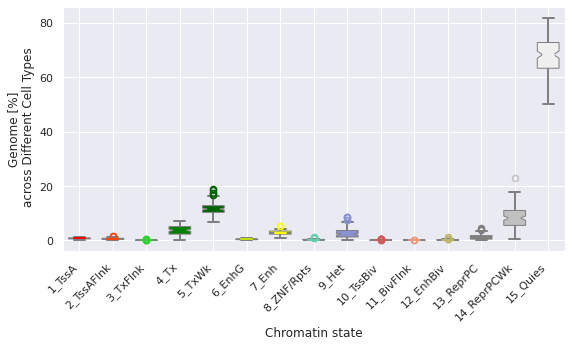

In [347]:
temp_df, trans_df=prop_data2df(path='../database/conserv_overlap/')

In [304]:
css_color_dict.keys()

dict_keys(['TssA', 'TssAFlnk', 'TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts', 'Het', 'TssBiv', 'BivFlnk', 'EnhBiv', 'ReprPC', 'ReprPCWk', 'Quies'])

In [330]:
list(range(1,15))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
## cutting telomere

In [395]:
len(all_unit_css[0])

1246253

In [402]:
len(all_unit_css[0][1246240:])

13

In [348]:
fa_file_path="../database/hg19/genome.fa"

In [363]:
str_eg="NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"
str_eg.count("N")

50

In [360]:
chr_list=["chr1","chr2","chr3","chr4,","chr5","chr6","chr7","chr8",
          "chr9","chr10","chr11","chr12,","chr13","chr14","chr15","chr16",
          "chr17","chr18","chr19","chr20,","chr21","chr22","chrX","chrY","chrM"]

In [392]:
with open(fa_file_path) as infile:
    for i, line in enumerate(infile):
        if ">" in line:
            no_n=0
            print(i+1)
            print(line)  
        elif "N" in line:
            no_n+=line.count("N")
        else:
            break
    print(no_n)

1
>chr1

10000


In [382]:
def fa2reducedBy50(fa_file_path):
    with open(fa_file_path) as infile:
        print("".join(line[0] for line in infile if not ">"))

In [383]:
fa2reducedBy50(fa_file_path)

### Genome statistics test

In [402]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [403]:
css_gene_lst_all=compGene2css(whole_gene_file,df)

In [404]:
q_cnt_lst, not_q_cnt_lst=QnonQforCell(all_files=all_files,whole_gene_file=whole_gene_file)

In [469]:
# with open("./temp_files/q_cnt_lst.txt", "w") as f:
#     f.write("".join(str(q_cnt_lst)))

with open("../database/temp_files/q_cnt_lst", "wb") as f:
    pickle.dump(q_cnt_lst, f)

In [421]:
with open("./temp_files/q_cnt_lst", "rb") as f:
    q_cnt_lst_pickled=pickle.load(f)

In [423]:
type(q_cnt_lst_pickled)

list

In [468]:
with open("../database/temp_files/not_q_cnt_lst", "wb") as g:
    pickle.dump(not_q_cnt_lst,g)

In [467]:
with open("../database/temp_files/css_gene_lst_all", "wb") as h:
    pickle.dump(css_gene_lst_all,h)

In [439]:
q_cnt_data=pd.DataFrame({"q_cnt":q_cnt_lst, "not_q_cnt":not_q_cnt_lst})

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

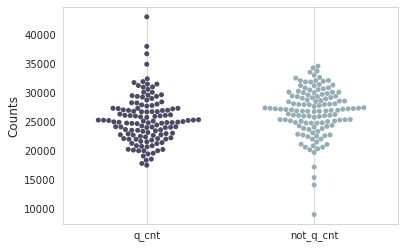

In [463]:
# sns.histplot(data=q_cnt_data, fill=False, element="step")
# sns.heatmap(data=q_cnt_data)
# sns.kdeplot(data=q_cnt_data)
fig=plt.figure(figsize=(6,4))
sns.swarmplot(data=q_cnt_data, palette="bone")
plt.grid(b=None)
plt.ylabel("Counts", fontsize=12)
plt.show()

In [465]:
type(css_gene_lst_all)

list

In [470]:
# generate three lists: 15th state-including gene count, gene length, proportion of 15th state per gene
#        cnt_o_lst : list of Quiescent state counts list per chromosome
#        gene_len_lst : list of gene length (in terms of chromatin state Anno.200bps) list per chromosome
#        pro_o_lst : list of proportion of Quiescent state per gene list per chromosome
cnt_o_lst, gene_len_lst, pro_o_lst=cntQinGene(css_gene_lst_all)

In [485]:
# flatten the cnt_o_lst, gene_len_lst, pro_o_lst and make it a df and then draw a distribution plot

def flatLst(lst):
    flatten_lst=[elm for sublst in lst for elm in sublst]
    return flatten_lst
cnt_o_lst_flat=flatLst(cnt_o_lst)

In [487]:
gene_len_lst_flat=flatLst(gene_len_lst)

In [489]:
pro_o_lst_flat=flatLst(pro_o_lst)

In [523]:
np.median(pro_o_lst_flat)

0.14151920132589757

In [586]:
np.mean(pro_o_lst_flat)

0.36192576596938386

In [493]:
three_df=pd.DataFrame({"gene_len":gene_len_lst_flat, "cnt_o":cnt_o_lst_flat, "o_proportion":pro_o_lst_flat})

In [495]:
three_df.tail()

,gene_len,cnt_o,o_proportion
52255,62493,62493,1.0
52256,62493,62493,1.0
52257,13239,13239,1.0
52258,13239,13239,1.0
52259,2528,2528,1.0


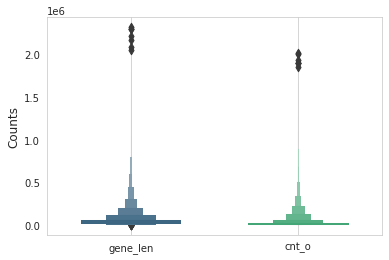

In [554]:
fig=plt.figure(figsize=(6,4))
# sns.swarmplot(data=three_df, palette="viridis")
# sns.histplot(data=three_df[["gene_len","cnt_o"]], kde=False, element="step", fill=False, bins=1000, palette="viridis")
# sns.set_style(style="white", rc={"patch.force_edgecolor":False})
sns.set_style(style="whitegrid")
sns.boxenplot(data=three_df[["gene_len","cnt_o"]],palette="viridis", width=0.6, linewidth=0.01)
plt.grid(b=None)
plt.ylabel("Counts", fontsize=12)
# plt.xlabel(fontsize=12)
plt.show()

/home/lee/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 6.365663164915176] is not finite

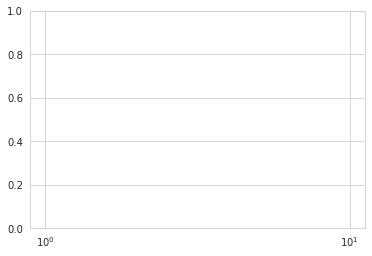

In [587]:
fig=plt.figure(figsize=(6,4))
# sns.swarmplot(data=three_df, palette="viridis")
# sns.histplot(data=three_df[["gene_len","cnt_o"]], kde=False, element="step", fill=False, bins=1000, palette="viridis")
# sns.set_style(style="white", rc={"patch.force_edgecolor":False})
sns.set_style(style="whitegrid")
sns.histplot(data=three_df[["gene_len","cnt_o"]],palette="viridis",log_scale=True) ### how to prevent zero??
plt.grid(b=None)
plt.ylabel("Counts", fontsize=12)
# plt.xlabel(fontsize=12)
plt.show()

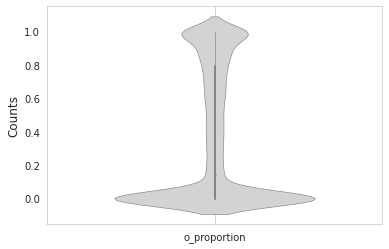

In [585]:
fig=plt.figure(figsize=(6,4))
# sns.swarmplot(data=three_df, palette="viridis")
# sns.histplot(data=three_df[["o_proportion"]], kde=False, element="step", fill=False, bins=1000, palette="viridis")
# sns.swarmplot(data=three_df[["o_proportion"]])
# sns.histplot(data=three_df[["o_proportion"]], bins=50) #,palette="viridis", width=0.6, linewidth=0.5)
sns.violinplot(data=three_df[["o_proportion"]], linewidth=0.6, inner="box", width=0.6, color="lightgray")
plt.grid(b=None)
plt.ylabel("Counts", fontsize=12)
plt.show()

<AxesSubplot:>

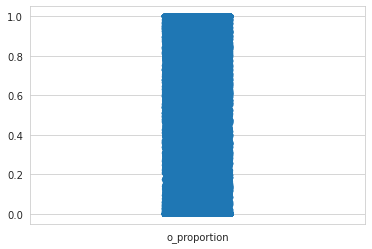

In [584]:
sns.stripplot(data=three_df[["o_proportion"]])

In [371]:
q_cnt_lst_all, not_q_cnt_lst_all=QnonQforChr(all_files=all_files,whole_gene_file=whole_gene_file)

NameError: name 'itertools' is not defined

In [ ]:
QnonQforCellHistT1(q_cnt_lst, not_q_cnt_lst, bin_size=15)

In [ ]:
QnonQforCellHistT2(q_cnt_lst, not_q_cnt_lst,bin_size)

In [ ]:
cntQinGene(css_gene_lst_all)